# Conditional Diffusion Models
__A simple example with closed-form expressions.__

In this notebook we explore continuous-time conditional diffusion models for the generation
of conditional samples. We consider the case where the data $p_0$ is a 2d multivariate normal,
with a **known** mean and covariance. In practice we would not know these quantities,
but we use them here to illustrate the concept and to allow for closed-form solutions of the
necessary equations. We are interested in the conditional distribution of the first component
of the multivariate normal, given the second component has a fixed value, that is
$$
p(x^{(1)} \mid x^{(2)} = a)
$$
where $a$ is a fixed value. We will use the notation $x^{(1)}$ and $x^{(2)}$ to refer to the first and
second components of the multivariate normal, respectively. We assume that during training we
have access to a dataset of samples from the **joint** data distribution $p_0$.

We consider the following SDE (known as the Variance Preserving formulation by Song et al.):
$$
dX_t = -\frac{\beta(t)}{2} X_t dt + \sqrt{\beta(t)} dW_t
$$
where $\beta(t)$ is a schedule that interpolates linearly between $\beta_{min}$ and $\beta_{max}$.

In [1]:
try:
    import setGPU
except ImportError:
    pass
from typing import Callable

from dataclasses import dataclass
from functools import partial
import numpy as np
import jax
import jax.numpy as jnp
import diffrax

from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt

# Some helper functions for linear algebra.
_solve_lower_triangular = partial(jax.scipy.linalg.solve_triangular, lower=True)  # L⁻¹ x
_solve_upper_triangular = partial(jax.scipy.linalg.solve_triangular, lower=False)  # U⁻¹ x
_t = lambda A: jnp.swapaxes(A, -1, -2)

def _safe_solve(A, b):
    """Solve the linear system Ax = b, where A is positive definite."""
    chol = jnp.linalg.cholesky(A + jnp.eye(len(A)) * 1e-8)
    return _solve_upper_triangular(_t(chol), _solve_lower_triangular(chol, b))

setGPU: Setting GPU to: 1


Below we define a dataclass to represent a SDE in the form $dX_t = f(t, X_t) dt + g(t, X_t) dW_t$,
where $f$ is the drift and $g$ is the diffusion. We also define a method to obtain the
variance-preserving SDE from a given beta schedule, where we defined the drift and diffusion as
$$
f(t, x) = -\frac{\beta(t)}{2} x
$$
and
$$
g(t, x) = \sqrt{\beta(t)} I
$$

In [2]:
BETA_MIN = .1
BETA_MAX = 20

@dataclass
class SDE:
    drift: Callable
    diffusion: Callable


def beta(t):
    return BETA_MIN + t * (BETA_MAX - BETA_MIN)


def int_beta(t):
    return (BETA_MAX - BETA_MIN) * t ** 2 / 2. + BETA_MIN * t
    

def get_variance_preserving_sde() -> SDE:
    """Return the SDE corresponding to the variance-preserving formulation."""

    def drift(t, x, *args):
        del args
        return - 0.5 * beta(t) * x

    def diffusion(t, x, *args):
        del args
        return jnp.sqrt(beta(t)) * jnp.eye(len(x))
    
    return SDE(
        drift=drift,
        diffusion=diffusion,
    )

## Data distribution
We consider a 2d multivariate normal distribution with mean $\mu$ and covariance matrix $\Sigma$.
We assume the variables have unit variance, and a correlation coefficient $\rho$ equal to 0.9.

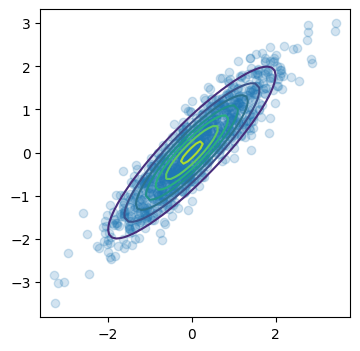

In [3]:

@dataclass
class MVN:
    mean: jnp.ndarray
    cov: jnp.ndarray

    def sample(self, key):
        return jax.random.multivariate_normal(key, self.mean, self.cov)


RHO = .9  # correlation coefficient
p0 = MVN(mean=jnp.zeros((2)), cov=jnp.array([[1., RHO], [RHO, 1.], ]))
num_data = 1_000
key = jax.random.PRNGKey(0)
data = jax.vmap(p0.sample)(jax.random.split(key, num_data))


def plot_mvn(mean, cov, ax, cmap="viridis"):
    # Create a grid of points at which to evaluate the PDF
    x, y = np.mgrid[-3:3:.1, -3:3:.1]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean, cov)
    z = rv.pdf(pos)
    ax.contour(x, y, z, cmap=cmap)


fig, ax = plt.figure(figsize=(4, 4)), plt.gca()
plot_mvn(p0.mean, p0.cov, ax, cmap="viridis")
ax.scatter(data[:, 0], data[:, 1], color="C0", alpha=.2);

Utility functions to solve SDEs using diffrax.
We implement a warp_time function which allows an SDE to be solved in reverse time
by warping the time argument of the drift and diffusion functions.

In [4]:
def warp_time(func, time_warp):
    """
    Assumes that the first argument of `func` is time.
    Returns a new function that warps the time argument of `func` by `time_warp`.
    """
    def updated_func(t, *args):
        return func(time_warp(t), *args)
    return updated_func


def solve_sde(sde: SDE, y0, key, reverse_time=False):
    """"Solve the SDE using diffrax."""
    t0, t1, dt0 = 1e-5, 1.0, 1e-3
    time_warp = lambda t: (t1 - t + t0) if reverse_time else t
    bm = diffrax.VirtualBrownianTree(t0=t0, t1=t1, tol=1e-3 / 2, shape=y0.shape, key=key)
    drift = diffrax.ODETerm(warp_time(sde.drift, time_warp))
    diffusion = diffrax.ControlTerm(warp_time(sde.diffusion, time_warp), bm)
    terms = diffrax.MultiTerm(drift, diffusion)
    solver = diffrax.Euler()
    if reverse_time:
        ts = [t0, .4, .6, .8, .9, t1]
    else:
        ts = [t0, .1, .2, .4, .8, t1]
    saveat = diffrax.SaveAt(ts=ts)
    return diffrax.diffeqsolve(terms, solver, t0, t1, dt0, y0, saveat=saveat)

## Forward SDE
We solve the forward SDE for each data point, and plot the samples at different times.

In [5]:
forward_sde = get_variance_preserving_sde()
key, bm_key = jax.random.split(key)
keys = jax.random.split(bm_key, num_data)
sol = jax.vmap(lambda y0, k: solve_sde(forward_sde, y0, k))(data, keys)

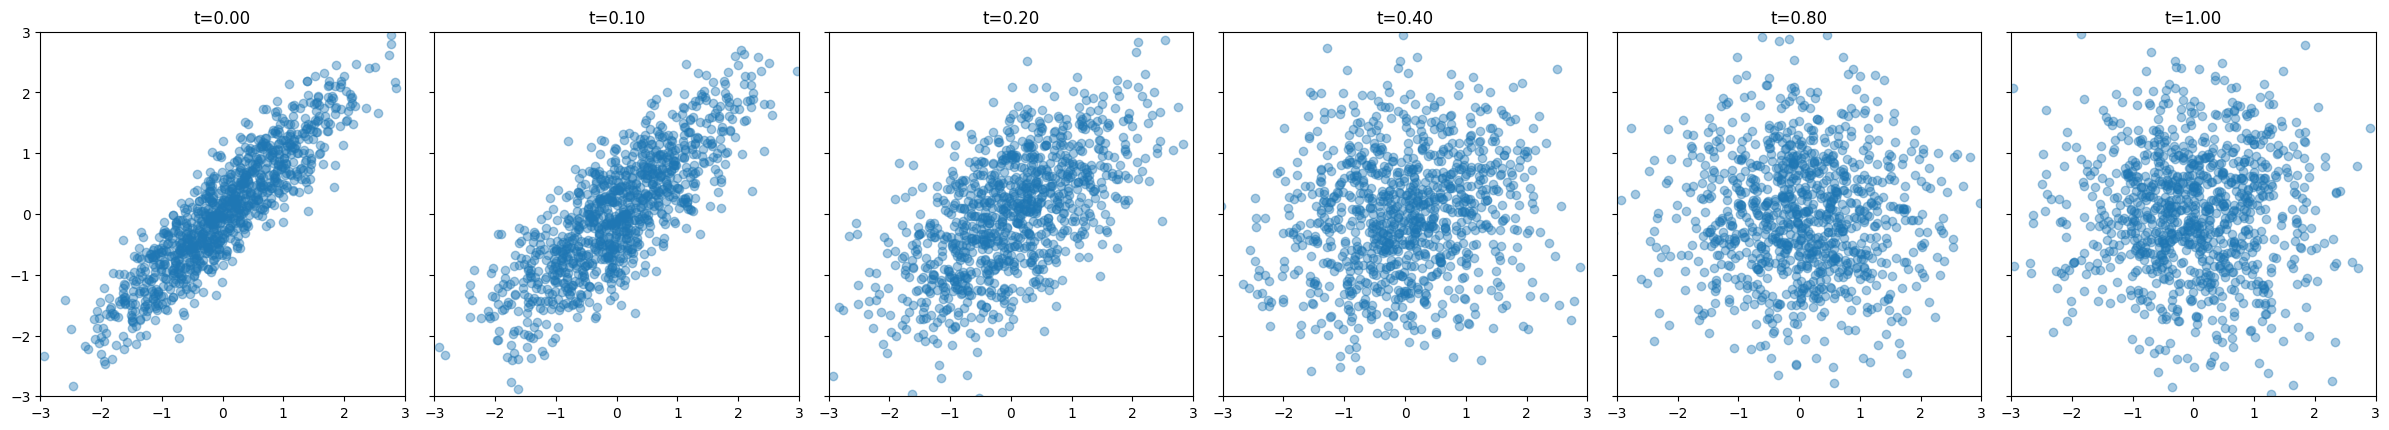

In [6]:
def clean_axes(ax, t):
    ax.set_title(f"t={t:.2f}")
    ax.set_aspect("equal")
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

def plot_run(ts, xt):
    """
    ts: array of shape (num_timesteps,)
    ys: array of shape (num_samples, num_timesteps, 2) containing x_t.
    """
    num_timesteps = len(ts)
    fig, axes = plt.subplots(1, num_timesteps, figsize=(4 * num_timesteps, 4), sharey=True, sharex=True)
    axes = axes.ravel()
    for i in range(num_timesteps):
        axes[i].scatter(xt[:, i, 0], xt[:, i, 1], color="C0", alpha=.4)
        clean_axes(axes[i], ts[i])
    plt.tight_layout()
    return axes

plot_run(sol.ts[0], sol.ys);

From the plot we see that the process is approximately stationary at $t=1$
and close to a reference distrbution $p_{ref}$ (in this case the distribution $\mathcal{N}(0,I)$).
$$
p_{t=1}(x_t) \approx p_{ref}(x) = \mathcal{N}(0, I)
$$

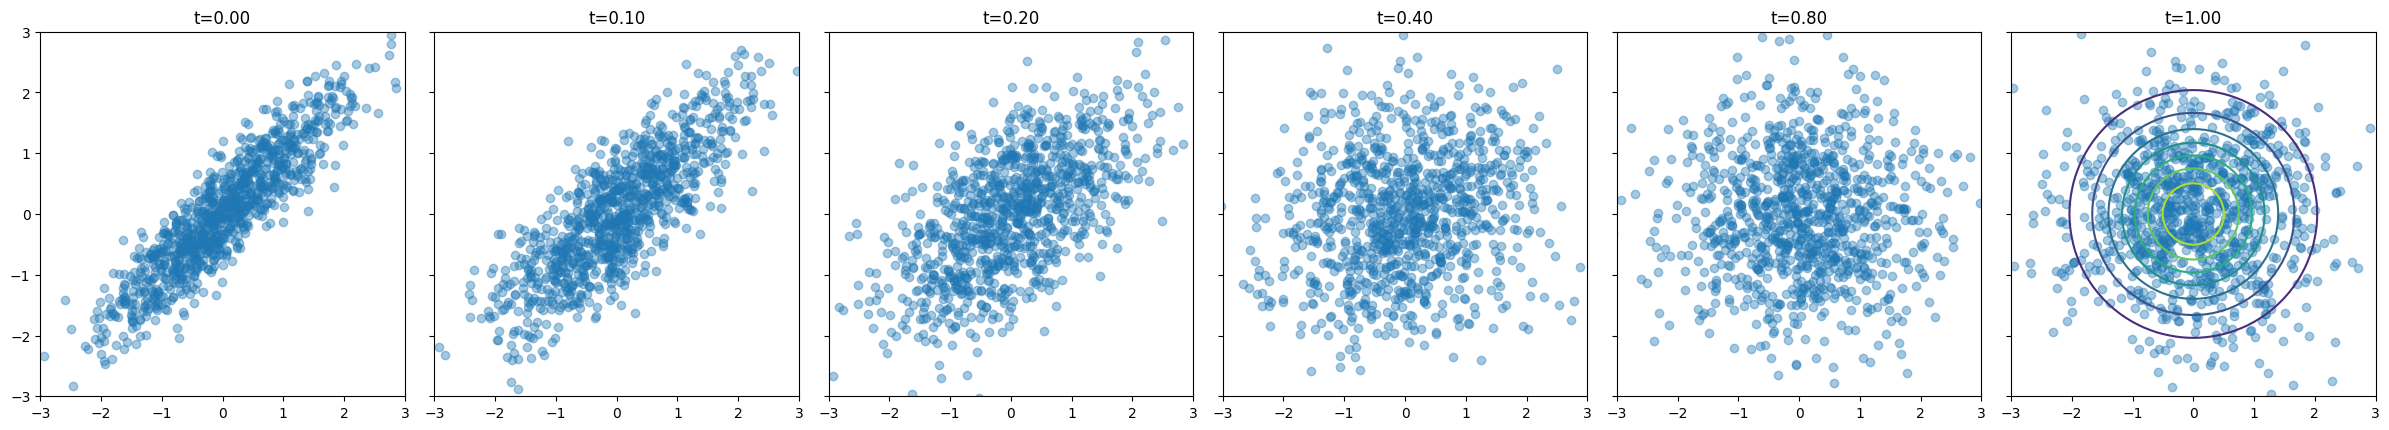

In [7]:
p_ref = MVN(mean=jnp.zeros((2)), cov=jnp.eye(2))
plot_run(sol.ts[0], sol.ys);
plot_mvn(p_ref.mean, p_ref.cov, plt.gca(), cmap="viridis")

## Reverse SDE
We now focus our attention to the reverse SDE, which is defined as
$$
dZ_t = \Big(\frac{\beta(t)}{2} X_t + \beta(t) \nabla_{Z_t} \log p_t(Z_t)\Big) dt + \sqrt{\beta(t)} d\tilde{W}_t
$$
where time run backwards from $t=1$ to $t=0$. Assuming we have access to the true score function and we initialise
the process by samples from $X_1$, then $\textrm{Law} Z_0 = \textrm{Law} X_0$.

We approximate samples from $X_1$ by simply using the reference distribution $p_{ref}$, as we know
this is close to the distribution of the forward SDE at $t=1$. We now focus our attention on
obtaining the score function $\nabla_{Z_t} \log p_t(Z_t)$.

As we have access to the true data distribution $p_0$, we can compute $p_t$ analytically and
obtain its gradient (i.e. score).
A property of the variance preserving formulation is that the distribution $p_{t|0}$ is a multivariate
normal with mean $\mu_{t|0}$ and covariance $\Sigma_{t|0}$ given by
$$
p_{t|0}(x_t | x_0) = \mathcal{N}(\textrm{e}^{-\gamma_t/2}x_0, (1 - \textrm{e}^{-\gamma_t}) I)
$$
where $\gamma_t = \int_0^t \beta(s) ds$.
We compute $p_t$ by marginalising over the data distribution
$$
p_t(x_t) = \int p_{t|0}(x_t | x_0) p_0(x_0) dx_0
$$
with $p_0 = \mathcal{N}(\mu_0, \Sigma_0)$ this gives
$$
p_t(x_t) = \mathcal{N}(\textrm{e}^{-\gamma_t/2}\mu_0, (1 - \textrm{e}^{-\gamma_t}) I + \textrm{e}^{-\gamma_t} \Sigma_0)
$$
The score function is then given by
$$
\nabla_{Z_t} \log p_t(Z_t) = - \Sigma_t^{-1} (Z_t - \mu_t).
$$

In [8]:
def score(t, x):
    mu_t = p0.mean * jnp.exp(-int_beta(t) / 2.)
    Sigma_t = (1.0 - jnp.exp(-int_beta(t))) * jnp.eye(len(x)) + jnp.exp(-int_beta(t)) * p0.cov
    return - _safe_solve(Sigma_t, x - mu_t)


def reverse_drift(t, x, *args):
    del args
    return -forward_sde.drift(t, x) + beta(t) * score(t, x)


reverse_sde = SDE(
    drift=reverse_drift,
    diffusion=forward_sde.diffusion,
)

We now solve the reverse SDE for each data point, and plot the samples at different times.
We start by sampling from the reference distribution $p_{ref}$ at $t=1$.

In [9]:
key, zT_key = jax.random.split(key)
zT = jax.vmap(p_ref.sample)(jax.random.split(zT_key, num_data))
key, bm_key = jax.random.split(key)
keys = jax.random.split(bm_key, num_data)
rev_sol = jax.vmap(lambda y0, k: solve_sde(reverse_sde, y0, k, reverse_time=True))(zT, keys)

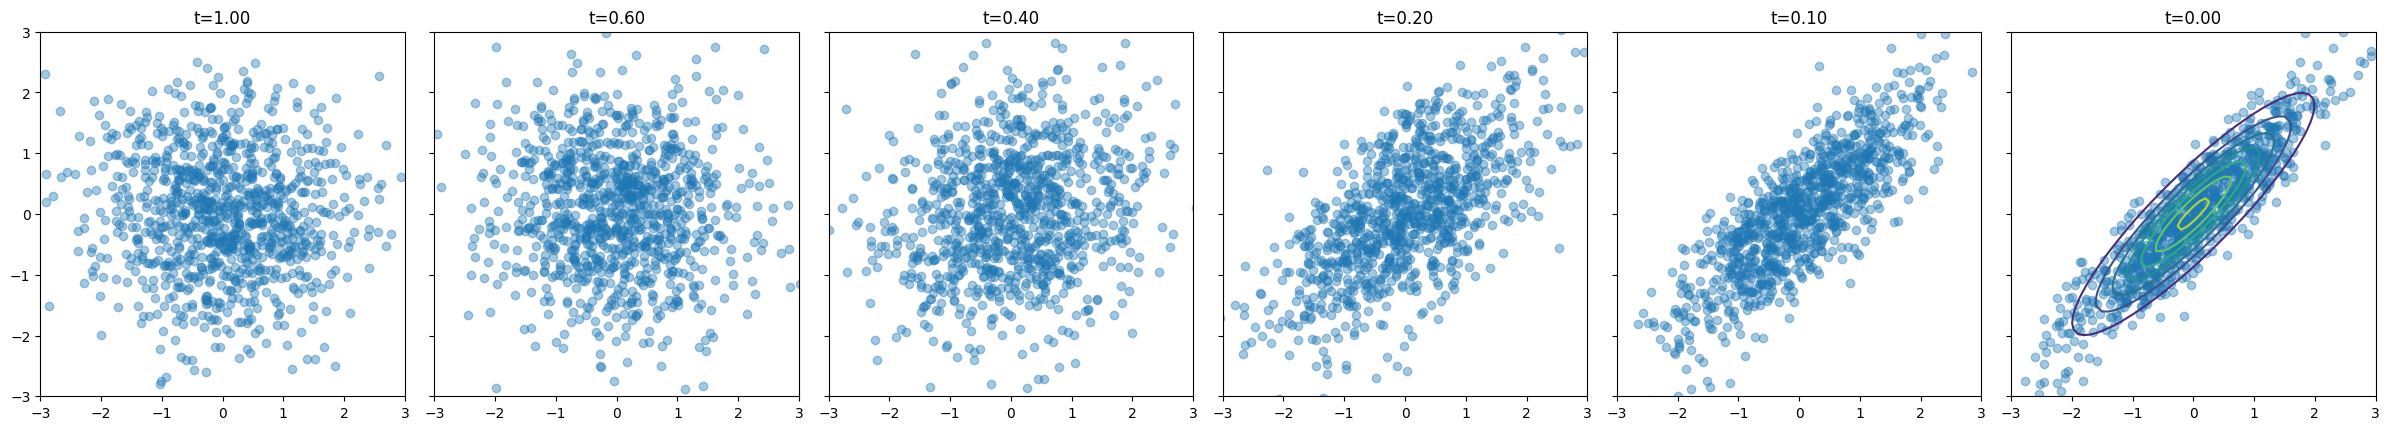

In [10]:
plot_run(1. - rev_sol.ts[0], rev_sol.ys);
plot_mvn(p0.mean, p0.cov, plt.gca(), cmap="viridis")

## Conditional Diffusion
So far we have seen how to traverse the SDE forward and backward in time.
The backward process is usually of interest as it allows us to sample from approximately $p_0$,
which is the distribution of interest. However, we are often interested in sampling from
the conditional distribution.
$$
p(x_0^{(1)} \mid x_0^{(2)} = a).
$$

Let assume the more general formulation where we are interested in samples from
$$
p(x_0 \mid P x_0 = a)
$$
where $P$ is a projection matrix. In our case $P$ is the projection onto the first component.

We can obtain samples from this distribution by solving the reverse SDE, but now
we require the score function $\nabla_{x_t} \log p(x_t | P x_0 = a)$ to be conditioned on the
constraint $P x_0 = a$.
We can obtain this score function by applying Bayes rule

\begin{align}
\nabla_{x_t} \log p(x_t | P x_0 = a) &= \nabla_{x_t} \log p(x_t, P x_0 = a) - \nabla_{x_t} \log p(P x_0 = a) \\
&= \nabla_{x_t} \log p_t(x_t) + \nabla_{x_t} \log p(P x_0 = a | x_t)
\end{align}
We have access to the first term as it corresponds to the score function of the reverse SDE computed earlier.
The second term is given by
$$
p(P x_0 = a | x_t) = \int \mathbb{I}(P x_0 = a) p_{t|0}(x_0 | x_t) dx_0
$$
where $\mathbb{I}$ is the indicator function.

We require $p_{0|t}$
$$
p_{0|t}(x_0 | x_t) \propto  {p_0(x_0)\,p(x_t | x_0)}
$$
which we can compute in closed form given the Gaussianity of $p_0$ and $p_{t|0}$. The result is
another multivariate normal distribution with mean $\mu_{0|t}$ and covariance $\Sigma_{0|t}$ given by

\begin{align}
\mu_{0|t} &= (\Sigma_{t|0} + \textrm{e}^{-\gamma_t}\Sigma_0)^{-1}(\Sigma_{t|0}\mu_0 + \mathrm{e}^{-\gamma_t} \Sigma_0 y_t) \\
\Sigma_{0|t} &= (\Sigma_{t|0} + \textrm{e}^{-\gamma_t}\Sigma_0)^{-1}(\Sigma_0\Sigma_{t|0})
\end{align}

Combining these results we get
$$
p(P x_0 = a | x_t) = \mathcal{N}(a | P \mu_{0|t}, P \Sigma_{0|t} P^\top)
$$

We start by implementing and visualizing the function to compute the conditional distribution $p_{0|t}$.

In [11]:
def p0t(t, x):
    Sigma_t_given_0 = (1.0 - jnp.exp(-int_beta(t))) * jnp.eye(len(x))
    denum = Sigma_t_given_0 + p0.cov * jnp.exp(-int_beta(t))
    mean = _safe_solve(denum, Sigma_t_given_0 @ p0.mean + p0.cov * jnp.exp(-int_beta(t)) @ x)
    cov = _safe_solve(denum, p0.cov @ Sigma_t_given_0)
    return mean, cov

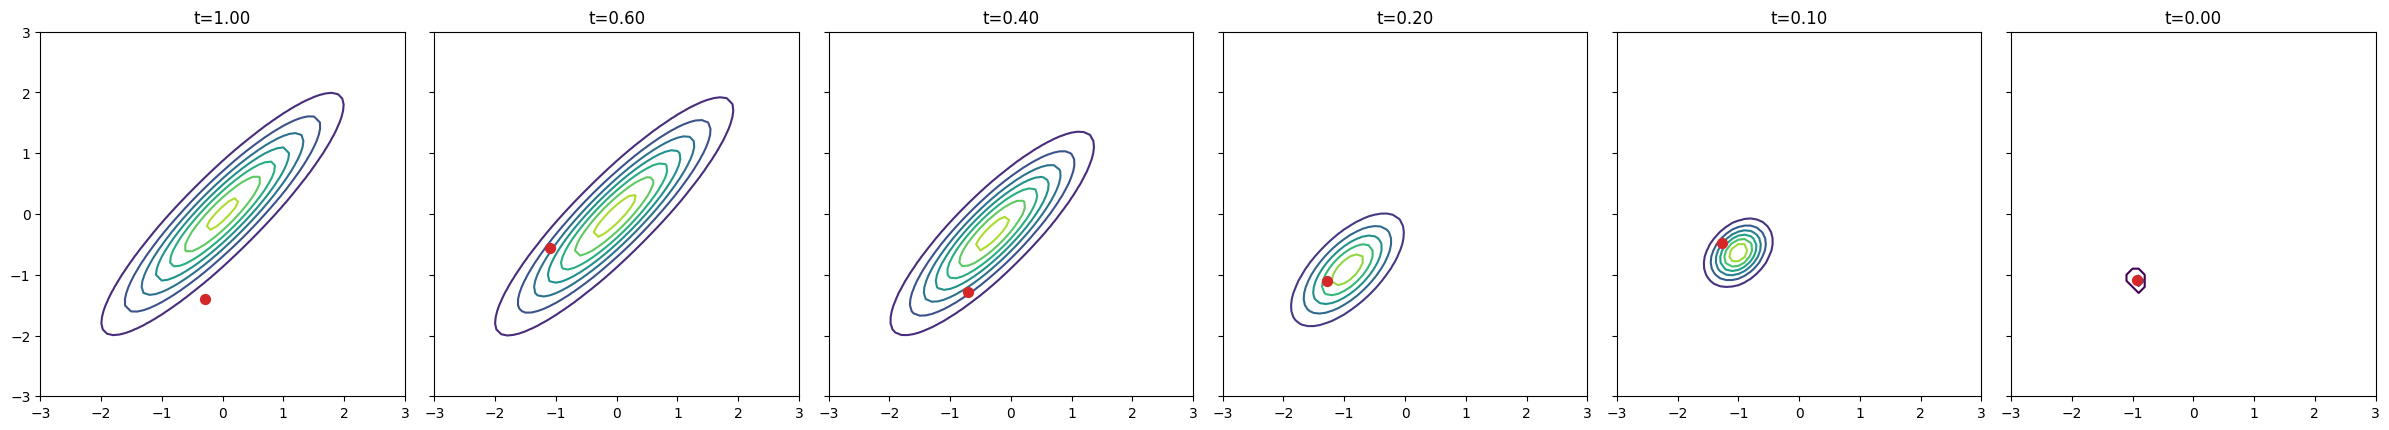

In [12]:
# This distribution estimates the 'origin' of the process at time t=0 given the value of the process at time t.
# We can visualise this distribution at different times for a single point x_t.

num_timesteps = len(sol.ys[0])
fig, axes = plt.subplots(1, num_timesteps, figsize=(4 * num_timesteps, 4), sharey=True, sharex=True)
idx = 44
for i in range(len(axes.ravel())):
    t = 1. - rev_sol.ts[idx, i]
    m, c = p0t(t, rev_sol.ys[idx, i])
    c = c + 1e-5 * jnp.eye(len(c))  # add jitter to avoid numerical issues in plotting
    plot_mvn(m, c, axes[i])
    axes[i].scatter(*rev_sol.ys[idx, i, :], color="C3", s=50, zorder=10)
    clean_axes(axes[i], t)
plt.tight_layout()

Not surprisingly, the distribution centers around x_t for smaller values of t.
In contrast, at t=1 the distribution is given by the data distribution itself $p_0$, which means
that a point at the end of the process could have originated from any point in the data distribution.

The above derivation for general $P$ can be simplified in our case as $P$ is the projection onto the first component.
$$
p(P x_0 = a | x_t) = \mathcal{N}(a | \mu_{0|t}^{(1)}, \Sigma_{0|t}^{(1,1)})
$$

In [13]:
def log_marginal_p0t(t, x, value):
    mean, cov = p0t(t, x)
    mean1, var1 = mean[1], cov[1, 1]
    return jnp.log(jax.scipy.stats.norm.pdf(value, mean1, var1 ** 0.5))
    


Finally we traverse the reverse conditional process using the computed score for a particular value of a.

In [14]:
value_x2 = -0.75  # in the text referred to as a.

# We compute the gradient w.r.t. x_t from the marginal distribution using auto differentiation.
# TODO: check for analytical solution?
score_marginal_p0t = jax.grad(lambda t, x: log_marginal_p0t(t, x, value_x2), argnums=1)

def conditional_score(t, x):
    return score(t, x) + score_marginal_p0t(t, x)


def conditional_reverse_drift(t, x, *args):
    """Conditional drift uses updated score."""
    del args
    return -forward_sde.drift(t, x) + beta(t) * conditional_score(t, x)

conditional_reverse_sde = SDE(
    drift=conditional_reverse_drift,
    diffusion=forward_sde.diffusion,
)

key, bm_key = jax.random.split(key)
keys = jax.random.split(bm_key, num_data)
rev_cond_sol = jax.vmap(lambda y0, k: solve_sde(conditional_reverse_sde, y0, k, reverse_time=True))(zT, keys)

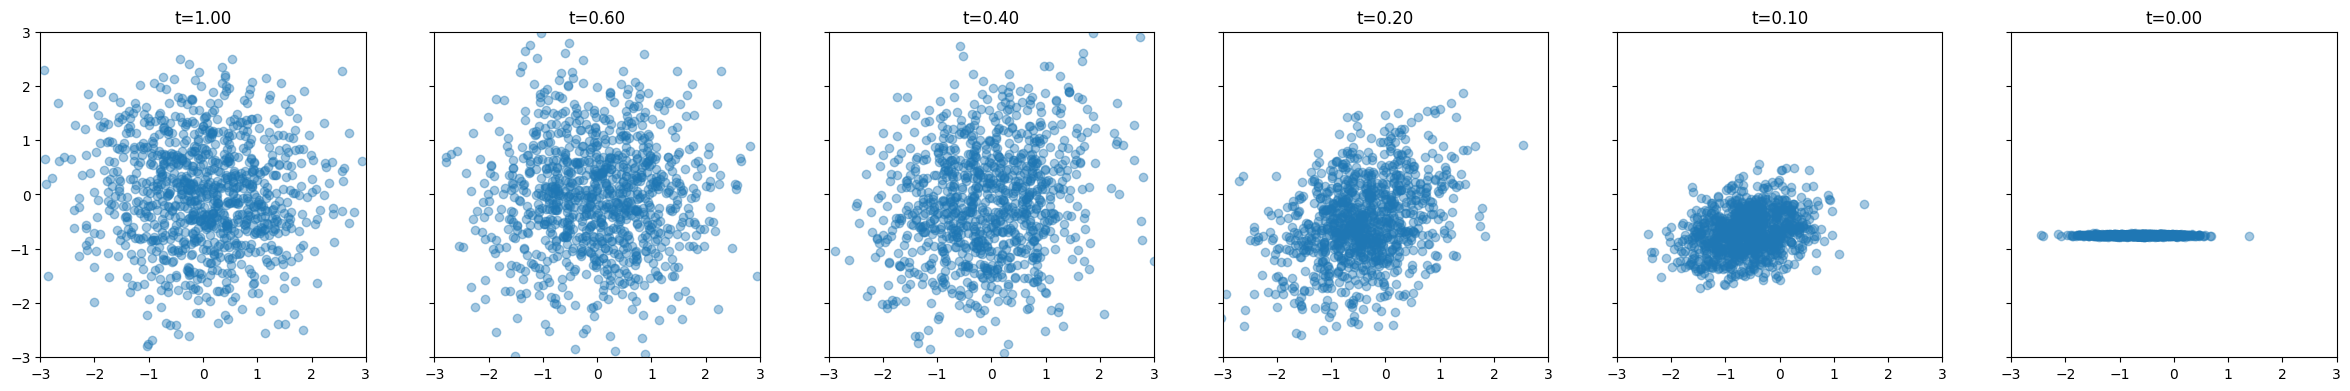

In [15]:
plot_run(1. - rev_cond_sol.ts[0], rev_cond_sol.ys);
plt.tight_layout()

We notice that the sampels satisfy the constraint that $x_0^{(2)}=a$

### Checks
We can verify correctness by comparing the distribution of the first component of the process
at t=0 with the conditional distribution of the first component of the data distribution.
Given that we have the true data distribution, we can compute the the pdf of the conditional
distribution $p(x_0^{(1)} \mid x_0^{(2)} = a)$.


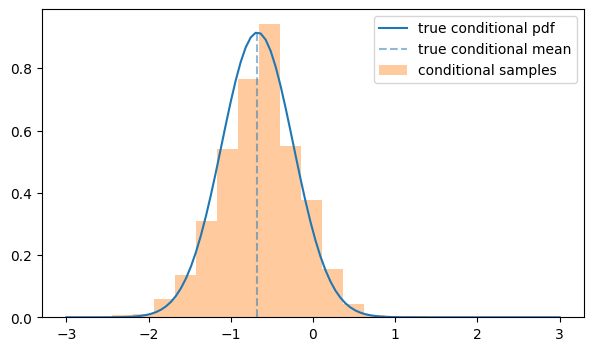

In [16]:

def gaussian_conditional(mean, cov, value_x2):
    """
    Assumes 2d multivariate normal, with mean 2d vector and cov 2x2 matrix.
    Computes conditional mean and variance of the first component, given the second component
    has value `value`.
    """
    mu1, mu2 = mean[0], mean[1]
    var1, var2, cov12 = cov[0, 0], cov[1, 1], cov[0, 1]
    safe_var2 = jnp.maximum(var2, 1e-6)
    cond_mean = mu1 + cov12 / safe_var2 * (value_x2 - mu2)
    cond_var = var1 - cov12 ** 2 / safe_var2
    return cond_mean, cond_var


fig, ax = plt.subplots(1, 1, figsize=(7, 4))
xx = jnp.linspace(-3, 3, 100)
m, v = gaussian_conditional(p0.mean, p0.cov, value_x2)
pdf = jax.vmap(lambda x: jax.scipy.stats.norm.pdf(x, m, v**.5))(xx)
ax.plot(xx, pdf, label="true conditional pdf");
ax.vlines(m, 0, pdf.max(), color="C0", alpha=.5, linestyle="--", label="true conditional mean");
ax.hist(rev_cond_sol.ys[:, -1, 0], bins=15, alpha=.4, density=True, label="conditional samples");
ax.legend();

## 1D Truncated Gaussian

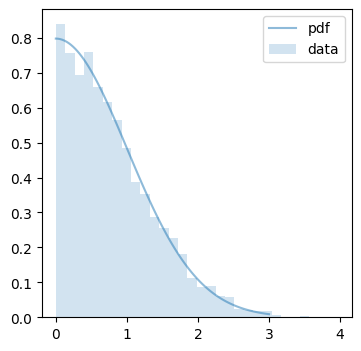

In [21]:
from jax.scipy.stats import truncnorm
from tensorflow_probability.substrates.jax.distributions import TruncatedNormal as TFPTruncatedNormal
from jax.scipy.special import erf

@dataclass
class TruncatedNormal:
    loc: float
    scale: float
    lower: float
    upper: float
    
    def sample(self, key):
        dist = TFPTruncatedNormal(self.loc, self.scale, self.lower, self.upper)
        return dist.sample(seed=key)
        # return jax.random.truncated_normal(key, self.lower, self.upper)

# Instantiate a truncated normal distribution.
lower = 0.
upper = jnp.inf
loc = 0.
scale = 1.
p_trunc = TruncatedNormal(loc, scale, lower=lower, upper=upper)

# Plot the truncated normal distribution.
num_data = 5_000
key = jax.random.PRNGKey(0)
key, step_key = jax.random.split(key)
data = jax.vmap(p_trunc.sample)(jax.random.split(step_key, num_data))

def plot_truncated_normal(dist: TruncatedNormal, ax, cmap="viridis", label=""):
    # Create a grid of points at which to evaluate the PDF
    x = np.linspace(max(dist.lower, -3.), min(dist.upper, 3.), 100)
    pdf = truncnorm.pdf(x, dist.lower, dist.upper, loc=dist.loc, scale=dist.scale)
    ax.plot(x, pdf, alpha=.5, label=label)

fig, ax = plt.figure(figsize=(4, 4)), plt.gca()
plot_truncated_normal(p_trunc, ax, cmap="viridis", label="pdf")
ax.hist(data, bins=30, color="C0", alpha=.2, density=True, label="data");
ax.legend();

In [22]:
# Define exact (unconditional) score
p0 = MVN(mean=jnp.zeros((1)), cov=jnp.eye(1))
def score(t, x):
    mu_t = p0.mean * jnp.exp(-int_beta(t) / 2.)
    Sigma_t = (1.0 - jnp.exp(-int_beta(t))) * jnp.eye(len(x)) + jnp.exp(-int_beta(t)) * p0.cov
    return - _safe_solve(Sigma_t, x - mu_t)

# Sample noise
p_ref = MVN(mean=jnp.zeros((1)), cov=jnp.eye(1))
key, zT_key = jax.random.split(key)
zT = jax.vmap(p_ref.sample)(jax.random.split(zT_key, num_data))

In [23]:
# def p0t(t, x):
#     Sigma_t_given_0 = (1.0 - jnp.exp(-int_beta(t))) * jnp.eye(len(x))
#     denum = Sigma_t_given_0 + p0.cov * jnp.exp(-int_beta(t))
#     mean = _safe_solve(denum, Sigma_t_given_0 @ p0.mean + p0.cov * jnp.exp(-int_beta(t)) @ x)
#     cov = _safe_solve(denum, p0.cov @ Sigma_t_given_0)
#     return mean, cov

In [34]:
def Phi(x):
    return 0.5 * (1. + erf(x / jnp.sqrt(2.)))

def log_marginal_p0t(t, x, lower, upper):
    mean, var = p0t(t, x)
    sigma = jnp.sqrt(var)
    alpha = (lower - mean) / sigma
    beta = (upper - mean) / sigma
    Z = Phi(beta) - Phi(alpha)
    return jnp.log(Z).squeeze()


score_marginal_p0t = jax.grad(lambda t, x: log_marginal_p0t(t, x, p_trunc.lower, p_trunc.upper), argnums=1)

def conditional_score(t, x):
    return score(t, x) + score_marginal_p0t(t, x)

def conditional_reverse_drift(t, x, *args):
    """Conditional drift uses updated score."""
    del args
    return -forward_sde.drift(t, x) + beta(t) * conditional_score(t, x)

conditional_reverse_sde = SDE(
    drift=conditional_reverse_drift,
    diffusion=forward_sde.diffusion,
)

key, bm_key = jax.random.split(key)
keys = jax.random.split(bm_key, num_data)

def solve_sde(sde: SDE, y0, key, reverse_time=False):
    """"Solve the SDE using diffrax."""
    t0, t1, dt0 = 1e-5, 1.0, 1e-3
    time_warp = lambda t: (t1 - t + t0) if reverse_time else t
    bm = diffrax.VirtualBrownianTree(t0=t0, t1=t1, tol=1e-3 / 2, shape=y0.shape, key=key)
    drift = diffrax.ODETerm(warp_time(sde.drift, time_warp))
    diffusion = diffrax.ControlTerm(warp_time(sde.diffusion, time_warp), bm)
    terms = diffrax.MultiTerm(drift, diffusion)
    solver = diffrax.Euler()
    if reverse_time:
        ts = [t0, .4, .6, .8, .9, t1]
    else:
        ts = [t0, .1, .2, .4, .8, t1]
    saveat = diffrax.SaveAt(ts=ts)
    return diffrax.diffeqsolve(terms, solver, t0, t1, dt0, y0, saveat=saveat)

rev_cond_sol = jax.vmap(lambda y0, k: solve_sde(conditional_reverse_sde, y0, k, reverse_time=True))(zT, keys)

(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)


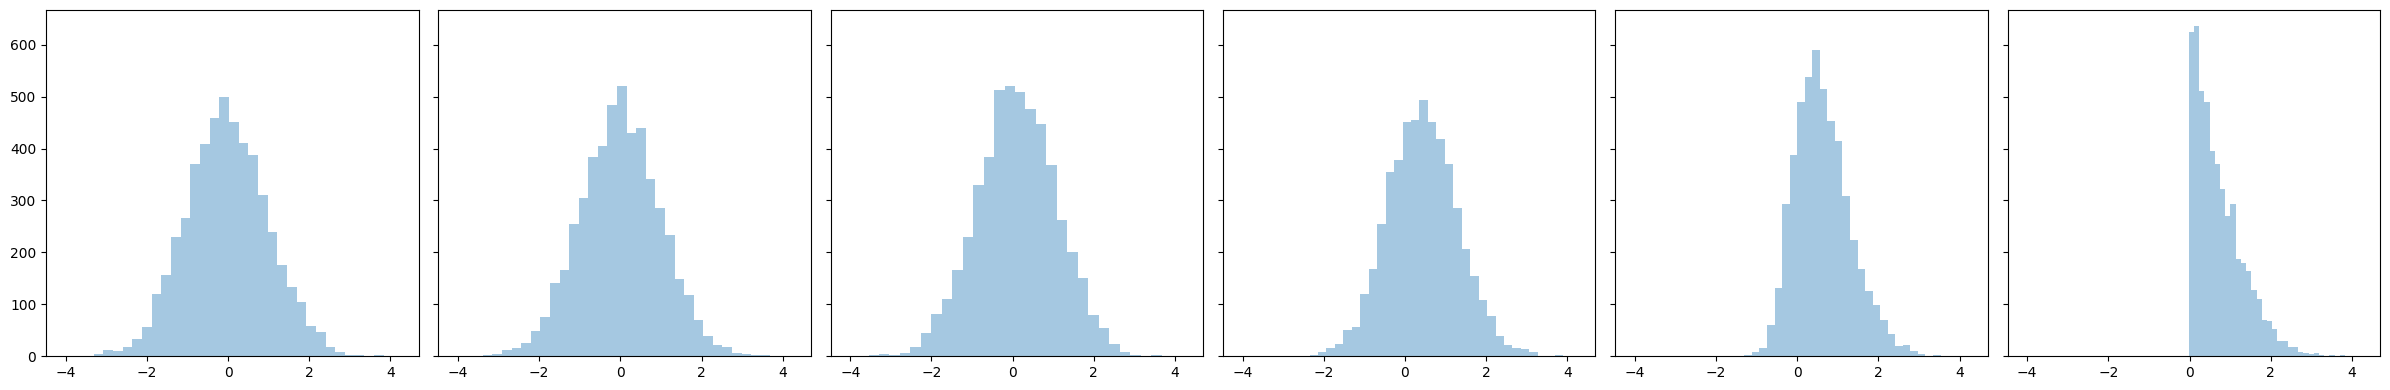

In [37]:
def plot_run(ts, xt):
    """
    ts: array of shape (num_timesteps,)
    ys: array of shape (num_samples, num_timesteps, 2) containing x_t.
    """
    num_timesteps = len(ts)
    fig, axes = plt.subplots(1, num_timesteps, figsize=(4 * num_timesteps, 4), sharey=True, sharex=True)
    axes = axes.ravel()
    for i in range(num_timesteps):
        axes[i].hist(xt[:, i].squeeze(-1), bins=30, color="C0", alpha=.4)
    plt.tight_layout()
    return axes

plot_run(1. - rev_cond_sol.ts[0], rev_cond_sol.ys);
plt.tight_layout()

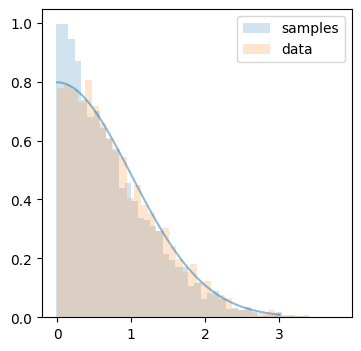

In [25]:

fig, ax = plt.figure(figsize=(4, 4)), plt.gca()
bins = 40
ax.hist(rev_cond_sol.ys[:, -1].reshape(-1), bins=bins, color="C0", alpha=.2, density=True, label="samples")
key, step_key = jax.random.split(key)
data = jax.vmap(p_trunc.sample)(jax.random.split(step_key, num_data))
ax.hist(data, bins=bins, color="C1", alpha=.2, density=True, label="data");
plot_truncated_normal(p_trunc, ax, cmap="viridis")
ax.legend()